C:\Users\Surya\AppData\Local\Temp\ipykernel_28280\2423545964.py:25: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['time_group'] = df['timestamp_first_attempt'].dt.floor('T')  # Grouped by minute
C:\Users\Surya\AppData\Local\Temp\ipykernel_28280\2423545964.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  bugs_per_minute = len(df) / total_time_minutes
C:\Users\Surya\AppData\Local\Temp\ipykernel_28280\2423545964.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  roi_coverage = df.groupby('roi_id').apply(lambda x: len(x) / x['roi_size_lines'].iloc[0])


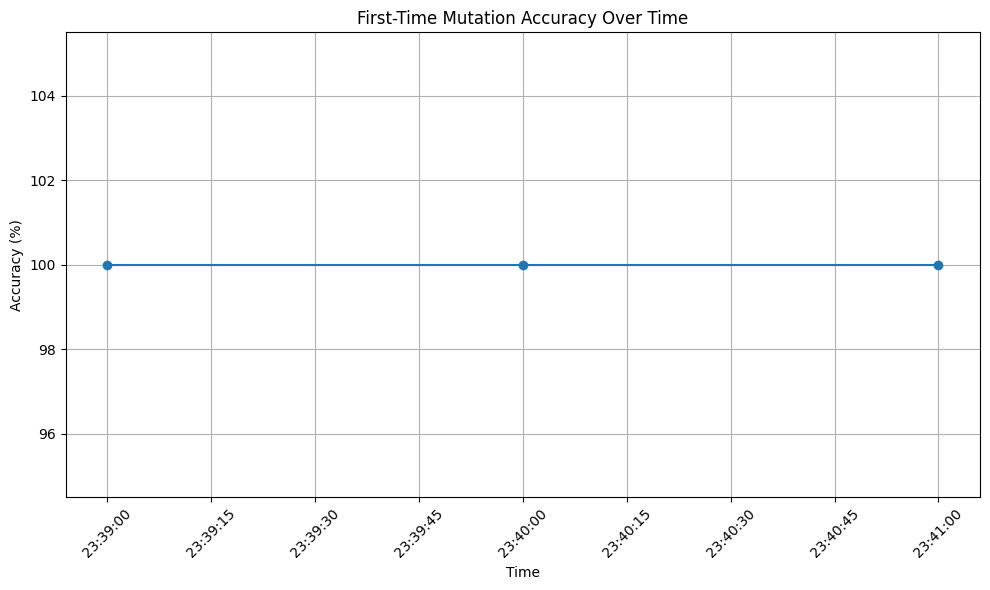

Accuracy per Mutation Class


,mutation_class,Accuracy %
0,bitwise_corruption,100.0
1,incorrect_data_size,100.0
2,logic_bug,100.0
3,wrong_assignment,100.0


Average Retries per Mutation Class


,mutation_class,Avg Retries
0,bitwise_corruption,0.0
1,incorrect_data_size,0.0
2,logic_bug,0.0
3,wrong_assignment,0.0


Mutation Class Distribution


,mutation_class,Count
0,bitwise_corruption,4
1,wrong_assignment,4
2,logic_bug,1
3,incorrect_data_size,1


Mutation Class Distribution per ROI


mutation_class,bitwise_corruption,incorrect_data_size,logic_bug,wrong_assignment
roi_id,,,,
roi_0,1,0,0,0
roi_1,2,0,0,2
roi_2,1,1,0,2
roi_3,0,0,1,0


{'Overall Accuracy %': np.float64(100.0),
 'Average Retries / Mutation': np.float64(0.0),
 'Bugs / Minute': np.float64(inf),
 'Total Generation Time (s)': np.float64(60.858474254608154),
 'Total Validation Time (s)': np.float64(0.0),
 'Total Rollback Time (s)': np.float64(0.0),
 'Avg Generation Time / Mutation (ms)': np.float64(6085.847425460815),
 'Avg Validation Time / Mutation (ms)': np.float64(0.0),
 'Avg Generation Time / Bug Scenario (ms)': np.float64(6016.780565182368),
 'Avg Validation Time / Bug Scenario (ms)': np.float64(0.0),
 'Average ROI Coverage': np.float64(0.03136603679500603),
 'Normalized Entropy Across ROIs': np.float64(0.798821717057664),
 'Redundant Bug Scenarios': np.int64(4)}

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import entropy
import json

# Load mutation log
df = pd.read_csv('../llm/out/mutation_log.csv')

# Convert datetime fields
df['timestamp_first_attempt'] = pd.to_datetime(df['timestamp_first_attempt'])
df['timestamp_final_success'] = pd.to_datetime(df['timestamp_final_success'])

# Add time delta for bug insertion
df['insertion_duration_sec'] = (df['timestamp_final_success'] - df['timestamp_first_attempt']).dt.total_seconds()

# 1. Accuracy
overall_accuracy = (df['mutation_applied_successfully'].sum() / len(df)) * 100
accuracy_per_class = df.groupby('mutation_class')['mutation_applied_successfully'].mean() * 100
avg_retries_per_mutation = df['num_retries'].mean()
avg_retries_per_class = df.groupby('mutation_class')['num_retries'].mean()

# Time-based accuracy graph
df['time_group'] = df['timestamp_first_attempt'].dt.floor('T')  # Grouped by minute
time_accuracy = df.groupby('time_group')['mutation_applied_successfully'].mean() * 100

# 2. Speed
total_time_minutes = df['insertion_duration_sec'].sum() / 60
bugs_per_minute = len(df) / total_time_minutes
gen_time_overall = df['generation_time_ms'].sum() / 1000
val_time_overall = df['validation_time_ms'].sum() / 1000
rollback_time_overall = df['rollback_time_ms'].sum() / 1000

gen_time_avg_mut = df['generation_time_ms'].mean()
gen_time_avg_scenario = df.groupby('bug_scenario_id')['generation_time_ms'].mean().mean()
val_time_avg_mut = df['validation_time_ms'].mean()
val_time_avg_scenario = df.groupby('bug_scenario_id')['validation_time_ms'].mean().mean()

# 3. Surface Coverage
roi_coverage = df.groupby('roi_id').apply(lambda x: len(x) / x['roi_size_lines'].iloc[0])
entropy_values = roi_coverage / roi_coverage.sum()
normalized_entropy = entropy(entropy_values, base=2) / np.log2(len(entropy_values))

# 4. Redundancy
bug_counts = df.groupby('bug_scenario_id')['failure_signature'].nunique()
redundant_scenarios = (bug_counts < 2).sum()
mutation_class_distribution = df['mutation_class'].value_counts()
roi_class_distribution = df.groupby('roi_id')['mutation_class'].value_counts().unstack(fill_value=0)

# Plot accuracy over time
plt.figure(figsize=(10, 6))
plt.plot(time_accuracy.index, time_accuracy.values, marker='o')
plt.title('First-Time Mutation Accuracy Over Time')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display metrics
results = {
    "Overall Accuracy %": overall_accuracy,
    "Average Retries / Mutation": avg_retries_per_mutation,
    "Bugs / Minute": bugs_per_minute,
    "Total Generation Time (s)": gen_time_overall,
    "Total Validation Time (s)": val_time_overall,
    "Total Rollback Time (s)": rollback_time_overall,
    "Avg Generation Time / Mutation (ms)": gen_time_avg_mut,
    "Avg Validation Time / Mutation (ms)": val_time_avg_mut,
    "Avg Generation Time / Bug Scenario (ms)": gen_time_avg_scenario,
    "Avg Validation Time / Bug Scenario (ms)": val_time_avg_scenario,
    "Average ROI Coverage": roi_coverage.mean(),
    "Normalized Entropy Across ROIs": normalized_entropy,
    "Redundant Bug Scenarios": redundant_scenarios
}

print("Accuracy per Mutation Class")
display(accuracy_per_class.reset_index(name='Accuracy %'))
print("Average Retries per Mutation Class")
display(avg_retries_per_class.reset_index(name='Avg Retries'))
print("Mutation Class Distribution")
display(mutation_class_distribution.reset_index(name='Count'))
print("Mutation Class Distribution per ROI")
display(roi_class_distribution)

display(results)